## 1. Pre-Processing Code

Running this step is not necessary, as we will provide a pre-processed dataset.

---

### Filter out unused games and users

In [ ]:
## filter.py - filters data directly from the .json files
import gzip
import ast
import tqdm

def load_python_dict_gz(file_path, head=None,key=None):
    data = []
    count = 0
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in tqdm.tqdm(f):
            line = line.strip()
            if not line:
                continue
            record = ast.literal_eval(line)
            if key is not None and key not in record:
                continue
            import pdb; pdb.set_trace()
            data.append(record)
            count += 1
            if head is not None and count >= head:
                break

    return data


def save_python_dict_gz(data, file_path):
    with gzip.open(file_path, "wt", encoding="utf-8") as f:
        for record in data:
            f.write(str(record))
            f.write("\n")

bundle_path = './bundle_data.json.gz'
review_path = '../steam_reviews.json.gz'
item_path = './australian_users_items.json.gz'
game_path = './steam_games.json.gz'

# bundles = load_python_dict_gz(bundle_path)
# ['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'items', 'bundle_discount']

reviews = load_python_dict_gz(review_path)

#88310
users = load_python_dict_gz(item_path,key='user_id')

# ['user_id', 'items_count', 'steam_id', 'user_url', 'items']

#32135
games = load_python_dict_gz(game_path,key='id')

users_dict = {user['user_id']: user for user in users}
games_dict = {game['id']: game for game in games}

new_users = {}
new_games = {}
new_reviews = []
count = 0

# save_python_dict_gz(list(users_dict.values()), './filtered_users_items.json.gz')
# save_python_dict_gz(list(games_dict.values()), './filtered_steam_games.json.gz')

with gzip.open('./australian_user_reviews.json.gz', 'rt', encoding='utf-8') as f:
    for line in tqdm.tqdm(f):
        line = line.strip()
        if not line:
            continue
        record = ast.literal_eval(line)
        if len(record['reviews']) == 0:
            continue
        f_review = record['reviews'][0]
        user_id = record['user_id']
        item_id = f_review['item_id']

        if user_id in users_dict and item_id in games_dict:
            if user_id not in new_users:
                new_users[user_id] = users_dict[user_id]
            if item_id not in new_games:
                new_games[item_id] = games_dict[item_id]
            new_reviews.append(record)

print(len(new_reviews)) #23538
print(len(list(new_users.values()))) #23250
print(len(list(new_games.values()))) #2143
save_python_dict_gz(new_reviews, './filtered_user_reviews.json.gz')
save_python_dict_gz(list(new_users.values()), './filtered_users_items.json.gz')
save_python_dict_gz(list(new_games.values()), './filtered_steam_games.json.gz')

FileNotFoundError: [Errno 2] No such file or directory: '../steam_reviews.json.gz'

### Load data and build training dataset

In [8]:
# process.py - converts filtered data into .pkl files
import gzip
import ast
import numpy as np
from collections import defaultdict
import tqdm
import pickle

def load_python_dict_gz(file_path, head=None):
    data = []
    count = 0
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in tqdm.tqdm(f):
            line = line.strip()
            if not line:
                continue
            record = ast.literal_eval(line)

            data.append(record)
            count += 1
            if head is not None and count >= head:
                break

    return data

review_path = './filtered_user_reviews.json.gz'
item_path = './filtered_users_items.json.gz'
game_path = './filtered_steam_games.json.gz'

# user
# user_id 76561197970982479
# items_count 277
# steam_id 76561197970982479
# user_url http://steamcommunity.com/profiles/76561197970982479
# items [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}]


# review
# user_id 76561197970982479
# user_url http://steamcommunity.com/profiles/76561197970982479
# reviews [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun 
# for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope 
# they do a sequel...so buy the game so I get a sequel!'}]

# game
# publisher Kotoshiro
# genres ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
# app_name Lost Summoner Kitty
# title Lost Summoner Kitty
# url http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/
# release_date 2018-01-04
# tags ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']
# discount_price 4.49
# reviews_url http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1
# specs ['Single-player']
# price 4.99
# early_access False
# id 761140
# developer Kotoshiro

#88310
users = load_python_dict_gz(item_path,head=100)
#32135
games = load_python_dict_gz(game_path)
reviews = load_python_dict_gz(review_path,head=100)

print(users[0].keys())
print(reviews[0].keys())
print(games[0].keys())

all_genres = set()
all_specs = set()
all_tags = set()
game_dict = {}

for g in games:
    if 'id' not in g:
        continue
    game_dict[g['id']] = g
    all_genres.update(g.get('genres', []))
    all_specs.update(g.get('specs', []))
    all_tags.update(g.get('tags', []))

genres_to_idx = {g: i for i, g in enumerate(sorted(all_genres))}
specs_to_idx = {s: i for i, s in enumerate(sorted(all_specs))}
tags_to_idx = {t: i for i, t in enumerate(sorted(all_tags))}
print(f'Number of genres: {len(genres_to_idx)}')
print('Genres to idx:', genres_to_idx)
print(f'Number of specs: {len(specs_to_idx)}')
print('Specs to idx:', specs_to_idx)
print(f'Number of tags: {len(tags_to_idx)}')
print('Tags to idx:', tags_to_idx)


0it [00:00, ?it/s]

99it [00:00, 337.91it/s]
2143it [00:00, 10219.31it/s]
99it [00:00, 9556.64it/s]

dict_keys(['user_id', 'items_count', 'steam_id', 'user_url', 'items'])
dict_keys(['user_id', 'user_url', 'reviews'])
dict_keys(['publisher', 'genres', 'app_name', 'sentiment', 'title', 'url', 'release_date', 'tags', 'reviews_url', 'specs', 'price', 'metascore', 'early_access', 'id', 'developer'])
Number of genres: 19
Genres to idx: {'Action': 0, 'Adventure': 1, 'Animation &amp; Modeling': 2, 'Casual': 3, 'Design &amp; Illustration': 4, 'Early Access': 5, 'Education': 6, 'Free to Play': 7, 'Indie': 8, 'Massively Multiplayer': 9, 'RPG': 10, 'Racing': 11, 'Simulation': 12, 'Software Training': 13, 'Sports': 14, 'Strategy': 15, 'Utilities': 16, 'Video Production': 17, 'Web Publishing': 18}
Number of specs: 39
Specs to idx: {'Captions available': 0, 'Co-op': 1, 'Commentary available': 2, 'Cross-Platform Multiplayer': 3, 'Downloadable Content': 4, 'Full controller support': 5, 'Game demo': 6, 'Gamepad': 7, 'HTC Vive': 8, 'In-App Purchases': 9, 'Includes Source SDK': 10, 'Includes level edito

In [ ]:
review_per_user = defaultdict(int)
recommand_per_user = defaultdict(int)
review_per_item = defaultdict(int)
recommand_per_item = defaultdict(int)
recommand_cnt = 0
for r in reviews:
    first_r = r['reviews'][0] if r['reviews'] else None
    if first_r:
        review_per_user[r['user_id']] += 1
        review_per_item[first_r['item_id']] += 1
        if first_r['recommend'] == True:
            recommand_cnt += 1
            recommand_per_user[r['user_id']] += 1
            recommand_per_item[first_r['item_id']] += 1

average_recommand = recommand_cnt / len(reviews)
print(f'average_recommand: {average_recommand}')
for k,v in recommand_per_user.items():
    recommand_per_user[k] = v / review_per_user[k] if review_per_user[k]>0 else 0.0
for k,v in recommand_per_item.items():
    recommand_per_item[k] = v / review_per_item[k] if review_per_item[k]>0 else 0.0

user_features = {}
for u in users:
    feature = {}
    total_playtime_forever = 0
    total_playtime_2weeks = 0
    total_price = 0.0
    geners_vec = np.zeros(len(genres_to_idx), dtype=np.float32)
    specs_vec = np.zeros(len(specs_to_idx), dtype=np.float32)
    tags_vec = np.zeros(len(tags_to_idx), dtype=np.float32)

    for item in u.get('items', []):
        total_playtime_forever += item.get('playtime_forever', 0)
        total_playtime_2weeks += item.get('playtime_2weeks', 0)
        price_raw = game_dict.get(item['item_id'], {}).get('price', 0.0)
        try:
            price = float(price_raw)
        except (ValueError, TypeError):
            price = 0.0
        total_price += price
        for g in game_dict.get(item['item_id'], {}).get('genres', []):
            if g in genres_to_idx:
                geners_vec[genres_to_idx[g]] += 1.0
        for s in game_dict.get(item['item_id'], {}).get('specs', []):
            if s in specs_to_idx:
                specs_vec[specs_to_idx[s]] += 1.0
        for t in game_dict.get(item['item_id'], {}).get('tags', []):
            if t in tags_to_idx:
                tags_vec[tags_to_idx[t]] += 1.0
    tmp = u.get('items', [])
    feature['items_count'] = u.get('items_count', 0)
    feature['playtime_forever'] = total_playtime_forever/feature['items_count'] if feature['items_count']>0 else 0
    feature['playtime_2weeks'] = total_playtime_2weeks/feature['items_count'] if feature['items_count']>0 else 0
    feature['average_price'] = total_price/feature['items_count'] if feature['items_count']>0 else 0
    feature['genres_vec'] = geners_vec
    feature['specs_vec'] = specs_vec
    feature['tags_vec'] = tags_vec
    # No recommendation ratio because the data sparsity
    user_features[u['user_id']] = feature

with open('user_features.pkl', 'wb') as f:
    pickle.dump(user_features, f, protocol=pickle.HIGHEST_PROTOCOL)

game_features = {}
for game in games:
    feature = {}
    genres_vec = np.zeros(len(genres_to_idx), dtype=np.float32)
    specs_vec = np.zeros(len(specs_to_idx), dtype=np.float32)
    tags_vec = np.zeros(len(tags_to_idx), dtype=np.float32)

    for g in game.get('genres', []):
        if g in genres_to_idx:
            genres_vec[genres_to_idx[g]] = 1.0
    for s in game.get('specs', []):
        if s in specs_to_idx:
            specs_vec[specs_to_idx[s]] = 1.0
    for t in game.get('tags', []):
        if t in tags_to_idx:
            tags_vec[tags_to_idx[t]] = 1.0
    price_raw = game_dict.get(game['id'], {}).get('price', 0.0)
    try:
        price = float(price_raw)
    except (ValueError, TypeError):
        price = 0.0
    feature['price'] = price
    feature['genres_vec'] = genres_vec
    feature['specs_vec'] = specs_vec
    feature['tags_vec'] = tags_vec
    feature['review_count'] = review_per_item.get(game['id'], 0)
    feature['recommend_ratio'] = recommand_per_item.get(game['id'], average_recommand)
    game_features[game['id']] = feature

print(len(game_features))
with open('game_features.pkl', 'wb') as f:
    pickle.dump(game_features, f, protocol=pickle.HIGHEST_PROTOCOL)

play_time_forever = {}
play_time_2weeks = {}
for u in users:
    for item in u.get('items', []):
        play_time_forever[(u['user_id'], item['item_id'])] = item.get('playtime_forever', 0)
        play_time_2weeks[(u['user_id'], item['item_id'])] = item.get('playtime_2weeks', 0)

training_data = []
for r in reviews:
    x = {}
    first_r = r['reviews'][0]
    user_id = r['user_id']
    item_id = first_r['item_id']
    user_feature = user_features[user_id]
    game_feature = game_features[item_id]
    cross_feature = {}
    cross_feature['playtime_forever'] = play_time_forever.get((user_id, item_id), 0)
    cross_feature['playtime_2weeks'] = play_time_2weeks.get((user_id, item_id), 0)

    x['user_feature'] = user_feature
    x['game_feature'] = game_feature
    x['cross_feature'] = cross_feature
    x['label'] = 1 if first_r['recommend'] == True else 0
    training_data.append(x)

with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

for i, x in enumerate(training_data[:2]):
    print(f"Sample {i}:")
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            print(f"User feature - {k}: array of shape {v.shape}")
        else:
            print(f"User feature - {k}: {v}")
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            print(f"Game feature - {k}: array of shape {v.shape}")
        else:
            print(f"Game feature - {k}: {v}")
    for k, v in x['cross_feature'].items():
        print(f"Cross feature - {k}: {v}")
    print(f"Label: {x['label']}")
    print("-----")

In [ ]:
# view.py - converts .pkl files into tensors for training
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

with open('training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

for i, x in enumerate(training_data[:2]):
    print(f"Sample {i}:")
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            print(f"User feature - {k}: array of shape {v.shape}")
        else:
            print(f"User feature - {k}: {v}")
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            print(f"Game feature - {k}: array of shape {v.shape}")
        else:
            print(f"Game feature - {k}: {v}")
    for k, v in x['cross_feature'].items():
        print(f"Cross feature - {k}: {v}")
    print(f"Label: {x['label']}")
    print("-----")

X_user = []
X_game = []
X_cross = []
y = []

for x in training_data:
    # User features
    user_feats = []
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            user_feats.extend(v.tolist())
        else:
            user_feats.append(v)
    X_user.append(user_feats)

    # Game features
    game_feats = []
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            game_feats.extend(v.tolist())
        else:
            game_feats.append(v)
    X_game.append(game_feats)

    # Cross features
    cross_feats = []
    for k, v in x['cross_feature'].items():
        cross_feats.append(v)
    X_cross.append(cross_feats)

    # Label
    y.append(x['label'])

X_user = np.array(X_user, dtype=np.float32)
X_game = np.array(X_game, dtype=np.float32)
X_cross = np.array(X_cross, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X = np.concatenate([X_user, X_game, X_cross], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)
print('length of training data:', X_train.shape[0])
print('length of test data:', X_test.shape[0])


## 2. Data Exploration

---

Download the data from: https://drive.google.com/file/d/1rR1L075ShjVgy3LMF0a07_-_u-293kch/view?usp=drive_link

In [ ]:
# view.py - converts .pkl files into tensors for training
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

with open('../data/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

X_user = []
X_game = []
X_cross = []
y = []

for x in training_data:
    # User features
    user_feats = []
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            user_feats.extend(v.tolist())
        else:
            user_feats.append(v)
    X_user.append(user_feats)

    # Game features
    game_feats = []
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            game_feats.extend(v.tolist())
        else:
            game_feats.append(v)
    X_game.append(game_feats)

    # Cross features
    cross_feats = []
    for k, v in x['cross_feature'].items():
        cross_feats.append(v)
    X_cross.append(cross_feats)

    # Label
    y.append(x['label'])

X_user = np.array(X_user, dtype=np.float32)
X_game = np.array(X_game, dtype=np.float32)
X_cross = np.array(X_cross, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X = np.concatenate([X_user, X_game, X_cross], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)
print('length of training data:', X_train.shape[0])
print('length of test data:', X_test.shape[0])

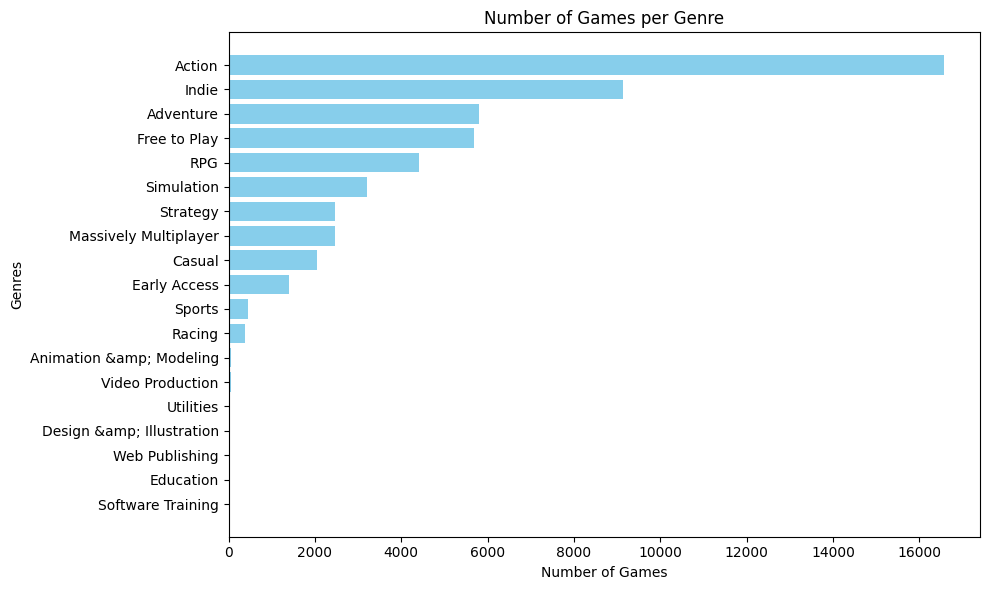

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_game_genres = np.array([
    x['game_feature']['genres_vec']
    for x in training_data
], dtype=np.float32)

genre_counts = X_game_genres.sum(axis=0)
genre_counts_dict = {genre: int(genre_counts[idx]) for genre, idx in genres_to_idx.items()}
genre_counts_dict = dict(sorted(genre_counts_dict.items(), key=lambda x: x[1], reverse=True))
genres = list(genre_counts_dict.keys())
counts = list(genre_counts_dict.values())

plt.figure(figsize=(10,6))
plt.barh(genres, counts, color='skyblue')
plt.xlabel('Number of Games')
plt.ylabel('Genres')
plt.title('Number of Games per Genre')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Number of Game Per Spec

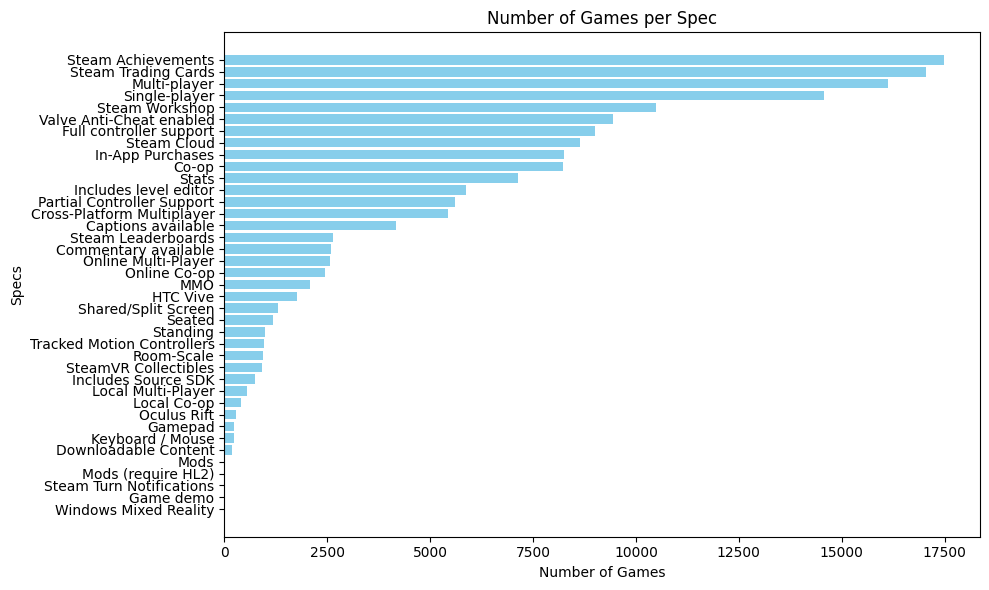

In [12]:
X_game_specs = np.array([
    x['game_feature']['specs_vec']
    for x in training_data
], dtype=np.float32)

specs_counts = X_game_specs.sum(axis=0)
specs_counts_dict = {spec: int(specs_counts[idx]) for spec, idx in specs_to_idx.items()}
specs_counts_dict = dict(sorted(specs_counts_dict.items(), key=lambda x: x[1], reverse=True))
specs = list(specs_counts_dict.keys())
counts = list(specs_counts_dict.values())

plt.figure(figsize=(10,6))
plt.barh(specs, counts, color='skyblue')
plt.xlabel('Number of Games')
plt.ylabel('Specs')
plt.title('Number of Games per Spec')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Is Recommendation Related to the User's Genre Preferences?

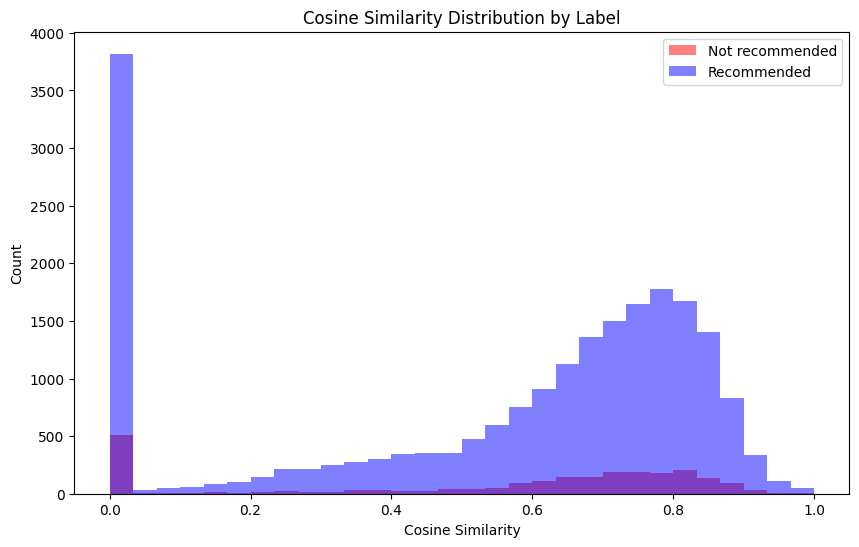

In [17]:
cosine_to_label = []

for x in training_data:
    user_feature = x['user_feature']['genres_vec']
    game_feature = x['game_feature']['genres_vec']
    cosine = np.dot(user_feature, game_feature) / (np.linalg.norm(user_feature) * np.linalg.norm(game_feature) + 1e-8)
    cosine_to_label.append((cosine, x['label']))

cosine_array = np.array(cosine_to_label)
cosines = cosine_array[:, 0].astype(float)
labels = cosine_array[:, 1].astype(int)

cosines_0 = cosines[labels == 0]
cosines_1 = cosines[labels == 1]

plt.figure(figsize=(10,6))
plt.hist(cosines[labels==0], bins=30, alpha=0.5, color='red', label='Not recommended')
plt.hist(cosines[labels==1], bins=30, alpha=0.5, color='blue', label='Recommended')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Cosine Similarity Distribution by Label')
plt.legend()
plt.show()

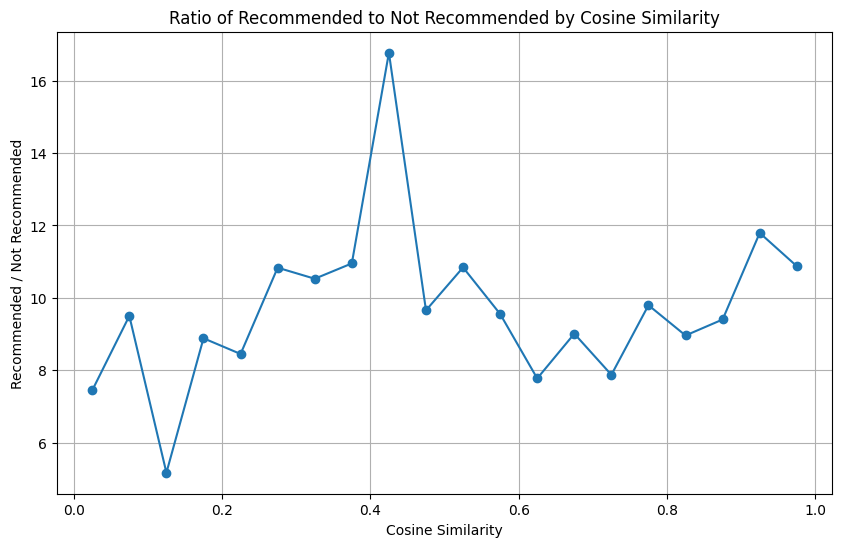

In [ ]:
bins = np.linspace(0, 1, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
ratios = []

for i in range(len(bins)-1):
    in_bin = (cosines >= bins[i]) & (cosines < bins[i+1])
    labels_in_bin = labels[in_bin]
    num_recommended = np.sum(labels_in_bin == 1)
    num_not_recommended = np.sum(labels_in_bin == 0)
    if num_not_recommended == 0:
        ratio = np.nan
    else:
        ratio = num_recommended / num_not_recommended
    ratios.append(ratio)
    
plt.figure(figsize=(10,6))
plt.plot(bin_centers, ratios, marker='o', linestyle='-')
plt.xlabel('Cosine Similarity')
plt.ylabel('Recommended / Not Recommended')
plt.title('Ratio of Recommended to Not Recommended by Cosine Similarity')
plt.grid(True)
plt.show()

### Is Recommendation Related to the User's Item Count?

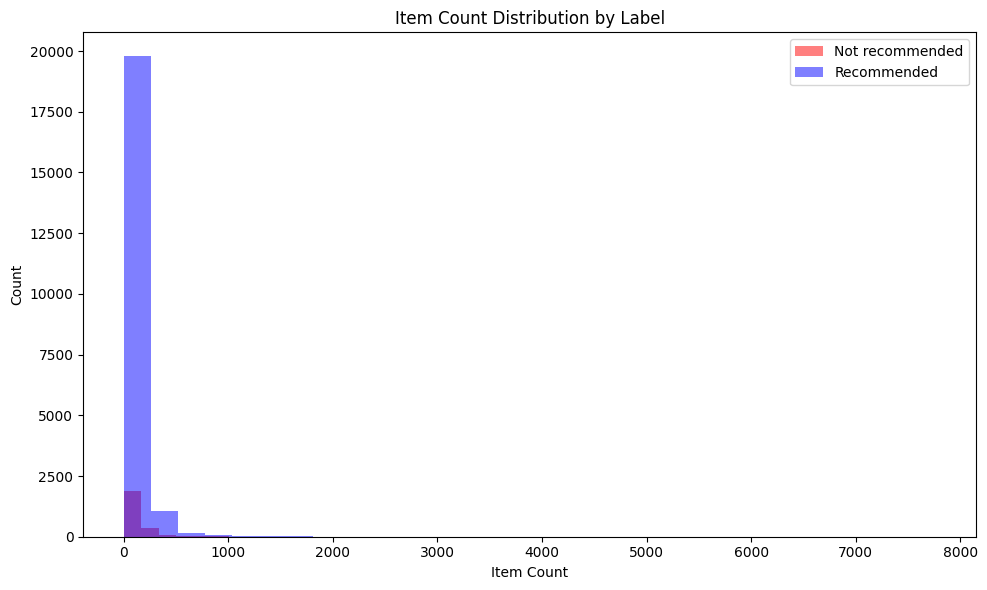

In [ ]:
item_count_to_label = []
for x in training_data:
    item_count = x['user_feature']['items_count']
    label = x['label']
    item_count_to_label.append((item_count, label))

item_count_array = np.array(item_count_to_label)
item_counts = item_count_array[:, 0].astype(int)
labels = item_count_array[:, 1].astype(int)
item_counts_0 = item_counts[labels == 0]
item_counts_1 = item_counts[labels == 1]
plt.figure(figsize=(10,6))
plt.hist(item_counts[labels==0], bins=30, alpha=0.5, color='red', label='Not recommended')
plt.hist(item_counts[labels==1], bins=30, alpha=0.5, color='blue', label='Recommended')

plt.xlabel('Item Count')
plt.ylabel('Count')
plt.title('Item Count Distribution by Label')
plt.legend()
plt.tight_layout()
plt.show()


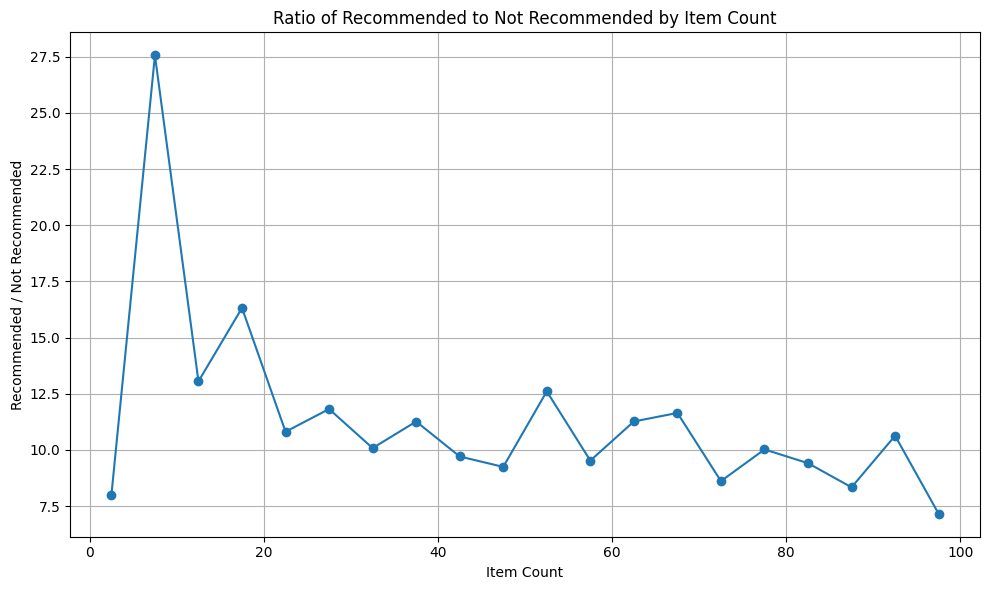

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

item_count_to_label = []
for x in training_data:
    item_count = x['user_feature']['items_count']
    label = x['label']
    item_count_to_label.append((item_count, label))

item_count_array = np.array(item_count_to_label)
item_counts = item_count_array[:, 0].astype(int)
labels = item_count_array[:, 1].astype(int)

max_count = 100
bins = np.linspace(0, max_count, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
ratios = []

for i in range(len(bins)-1):
    in_bin = (item_counts >= bins[i]) & (item_counts < bins[i+1])
    labels_in_bin = labels[in_bin]
    num_recommended = np.sum(labels_in_bin == 1)
    num_not_recommended = np.sum(labels_in_bin == 0)
    
    if num_not_recommended == 0:
        ratio = np.nan
    else:
        ratio = num_recommended / num_not_recommended
    ratios.append(ratio)

plt.figure(figsize=(10,6))
plt.plot(bin_centers, ratios, marker='o', linestyle='-')
plt.xlabel('Item Count')
plt.ylabel('Recommended / Not Recommended')
plt.title('Ratio of Recommended to Not Recommended by Item Count')
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Model Training
---

#### Gradient Boosted Decision Trees (XGBoost)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import optuna
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report


TRAINING_DATA_PATH = ".//data//training_data.pkl"

# code taken from view.py
def load_tensors(path, seed=42, test_size=0.2):
    # load pkl file
    with open(path, 'rb') as f:
        training_data = pickle.load(f)
        
    X_user = []
    X_game = []
    X_cross = []
    y = []

    for x in training_data:
        # User features
        user_feats = []
        for k, v in x['user_feature'].items():
            if isinstance(v, np.ndarray):
                user_feats.extend(v.tolist())
            else:
                user_feats.append(v)
        X_user.append(user_feats)

        # Game features
        game_feats = []
        for k, v in x['game_feature'].items():
            if isinstance(v, np.ndarray):
                game_feats.extend(v.tolist())
            else:
                game_feats.append(v)
        X_game.append(game_feats)

        # Cross features
        cross_feats = []
        for k, v in x['cross_feature'].items():
            cross_feats.append(v)
        X_cross.append(cross_feats)

        # Label
        y.append(x['label'])

    X_user = np.array(X_user, dtype=np.float32)
    X_game = np.array(X_game, dtype=np.float32)
    X_cross = np.array(X_cross, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    X = np.concatenate([X_user, X_game, X_cross], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, shuffle=True, stratify=y
    )
    
    # return training and testing data
    return X_train, X_test, y_train, y_test

# init tensors
x_train, x_test, y_train, y_test = load_tensors(TRAINING_DATA_PATH)

# optuna hyperparam tuning
def objective(trial: optuna.Trial) -> float:

    # hyper param search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.001, 0.75, log=True),
    }
    
    model = xgb.XGBClassifier( 
        **params,
        device='cuda',
        use_label_encoder=False,
    )
    
    model.fit(
        x_train,
        y_train,
        verbose=False
    )
    
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    
    # return value optuna will try to maximize
    return macro_f1
    

# --- script entry point ---
study = optuna.create_study(
    direction="maximize",
    study_name="xgb_recommender",
)   

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
})

best_model = xgb.XGBClassifier(
    **best_params,
    device='cuda',
    use_label_encoder=False,
)

best_model.fit(
    x_train,
    y_train,
    verbose=False,
)

# eval on test set
y_test_proba = best_model.predict_proba(x_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1:  {test_f1:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_test_pred))
    

#### Random Forest Classifier

In [ ]:
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load training data
with open('data/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

# print(f"Total samples: {len(training_data)}")

# Extract features and labels
X_user = []
X_game = []
X_cross = []
y = []

for x in training_data:
    # User features
    user_feats = []
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            user_feats.extend(v.tolist())
        else:
            user_feats.append(v)
    X_user.append(user_feats)

    # Game features
    game_feats = []
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            game_feats.extend(v.tolist())
        else:
            game_feats.append(v)
    X_game.append(game_feats)

    # Cross features
    cross_feats = []
    for k, v in x['cross_feature'].items():
        cross_feats.append(v)
    X_cross.append(cross_feats)

    # Label
    y.append(x['label'])

# Convert to numpy arrays
X_user = np.array(X_user, dtype=np.float32)
X_game = np.array(X_game, dtype=np.float32)
X_cross = np.array(X_cross, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Concatenate all features
X = np.concatenate([X_user, X_game, X_cross], axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

# print(f"Training set size: {X_train.shape[0]}")
# print(f"Test set size: {X_test.shape[0]}")

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest...")
rf_classifier.fit(X_train, y_train)
print("Training complete!")

# Make predictions on test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy (%): {test_accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Recommend', 'Recommend']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

#### Logisitic Regression

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
with open('../data/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

print(training_data[0])
print(len(training_data))

# Prepare features and labels
X_user = []
X_game = []
X_cross = []
y = []

for x in training_data:
    # User features
    user_feats = []
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            user_feats.extend(v.tolist())
        else:
            user_feats.append(v)
    X_user.append(user_feats)
    
    # Game features
    game_feats = []
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            game_feats.extend(v.tolist())
        else:
            game_feats.append(v)
    X_game.append(game_feats)
    
    # Cross features
    cross_feats = []
    for k, v in x['cross_feature'].items():
        cross_feats.append(v)
    X_cross.append(cross_feats)
    
    # Label
    y.append(x['label'])

# Combine all features
X = np.concatenate([
    np.array(X_user, dtype=np.float32),
    np.array(X_game, dtype=np.float32),
    np.array(X_cross, dtype=np.float32)
], axis=1)
y = np.array(y, dtype=np.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Positive rate in training: {y_train.mean():.3f}")
print(f"Positive rate in test: {y_test.mean():.3f}")
print()

# Train Logistic Regression
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=10000, random_state=42, class_weight='balanced', solver='liblinear', C=1.0)
lr_model.fit(X_train, y_train)
print("Training complete!")
print()

# Make predictions
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

print("Classification Report: Training Set")
print(classification_report(y_train, y_pred_train, target_names=['Not Recommend', 'Recommend']))

print("Evaluation Metrics: Training Set")
train_precision, train_recall, train_f1, train_support = precision_recall_fscore_support(
    y_train, y_pred_train, average=None, labels=[0, 1]
)

print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"{'Not Recommend':<15} {train_precision[0]:<12.4f} {train_recall[0]:<12.4f} {train_f1[0]:<12.4f} {train_support[0]:<12}")
print(f"{'Recommend':<15} {train_precision[1]:<12.4f} {train_recall[1]:<12.4f} {train_f1[1]:<12.4f} {train_support[1]:<12}")
print(f"{'Accuracy':<15} {'':<12} {'':<12} {accuracy_score(y_train, y_pred_train):<12.4f} {train_support.sum():<12}")
print(f"{'Macro Avg':<15} {precision_score(y_train, y_pred_train, average='macro'):<12.4f} {recall_score(y_train, y_pred_train, average='macro'):<12.4f} {f1_score(y_train, y_pred_train, average='macro'):<12.4f} {train_support.sum():<12}")
print(f"{'Weighted Avg':<15} {precision_score(y_train, y_pred_train, average='weighted'):<12.4f} {recall_score(y_train, y_pred_train, average='weighted'):<12.4f} {f1_score(y_train, y_pred_train, average='weighted'):<12.4f} {train_support.sum():<12}")
print()

print("Confusion Matrix: Training Set")
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
print()
print(f"True Negatives (TN): {cm_train[0,0]}")
print(f"False Positives (FP): {cm_train[0,1]}")
print(f"False Negatives (FN): {cm_train[1,0]}")
print(f"True Positives (TP): {cm_train[1,1]}")
print()

print("Classification Report: Test Set")
print(classification_report(y_test, y_pred_test, target_names=['Not Recommend', 'Recommend']))

print("Evaluation Metrics: Test Set")
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test, y_pred_test, average=None, labels=[0, 1]
)

print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"{'Not Recommend':<15} {test_precision[0]:<12.4f} {test_recall[0]:<12.4f} {test_f1[0]:<12.4f} {test_support[0]:<12}")
print(f"{'Recommend':<15} {test_precision[1]:<12.4f} {test_recall[1]:<12.4f} {test_f1[1]:<12.4f} {test_support[1]:<12}")
print(f"{'Accuracy':<15} {'':<12} {'':<12} {accuracy_score(y_test, y_pred_test):<12.4f} {test_support.sum():<12}")
print(f"{'Macro Avg':<15} {precision_score(y_test, y_pred_test, average='macro'):<12.4f} {recall_score(y_test, y_pred_test, average='macro'):<12.4f} {f1_score(y_test, y_pred_test, average='macro'):<12.4f} {test_support.sum():<12}")
print(f"{'Weighted Avg':<15} {precision_score(y_test, y_pred_test, average='weighted'):<12.4f} {recall_score(y_test, y_pred_test, average='weighted'):<12.4f} {f1_score(y_test, y_pred_test, average='weighted'):<12.4f} {test_support.sum():<12}")
print()

print("Confusion Matrix: Test Set")
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
print()
print(f"True Negatives (TN): {cm_test[0,0]}")
print(f"False Positives (FP): {cm_test[0,1]}")
print(f"False Negatives (FN): {cm_test[1,0]}")
print(f"True Positives (TP): {cm_test[1,1]}")
print()

print("Comparison of Training and Test Set Metrics")
print(f"{'Metric':<25} {'Training':<20} {'Test':<20}")
print(f"{'Accuracy':<25} {accuracy_score(y_train, y_pred_train):<20.4f} {accuracy_score(y_test, y_pred_test):<20.4f}")
print(f"{'Precision (Macro)':<25} {precision_score(y_train, y_pred_train, average='macro'):<20.4f} {precision_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'Recall (Macro)':<25} {recall_score(y_train, y_pred_train, average='macro'):<20.4f} {recall_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'F1-Score (Macro)':<25} {f1_score(y_train, y_pred_train, average='macro'):<20.4f} {f1_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'Precision (Weighted)':<25} {precision_score(y_train, y_pred_train, average='weighted'):<20.4f} {precision_score(y_test, y_pred_test, average='weighted'):<20.4f}")
print(f"{'Recall (Weighted)':<25} {recall_score(y_train, y_pred_train, average='weighted'):<20.4f} {recall_score(y_test, y_pred_test, average='weighted'):<20.4f}")
print(f"{'F1-Score (Weighted)':<25} {f1_score(y_train, y_pred_train, average='weighted'):<20.4f} {f1_score(y_test, y_pred_test, average='weighted'):<20.4f}")
print()

# Plot both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Recommend', 'Recommend'],
            yticklabels=['Not Recommend', 'Recommend'])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Recommend', 'Recommend'],
            yticklabels=['Not Recommend', 'Recommend'])
axes[1].set_title('Confusion Matrix - Test Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()

feature_names = []
# User features
for k in training_data[0]['user_feature'].keys():
    if isinstance(training_data[0]['user_feature'][k], np.ndarray):
        feature_names.extend([f'user_{k}_{i}' for i in range(len(training_data[0]['user_feature'][k]))])
    else:
        feature_names.append(f'user_{k}')
# Game features
for k in training_data[0]['game_feature'].keys():
    if isinstance(training_data[0]['game_feature'][k], np.ndarray):
        feature_names.extend([f'game_{k}_{i}' for i in range(len(training_data[0]['game_feature'][k]))])
    else:
        feature_names.append(f'game_{k}')
# Cross features
for k in training_data[0]['cross_feature'].keys():
    feature_names.append(f'cross_{k}')

coefficients = lr_model.coef_[0]
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"{'Rank':<6} {'Feature':<45} {'Coefficient':<15}")
for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:<6} {name:<45} {coef:>15.6f}")

#### Support Vector Machine (SVM)

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
with open('./data/training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

# Prepare features and labels
X_user = []
X_game = []
X_cross = []
y = []

for x in training_data:
    # User features
    user_feats = []
    for k, v in x['user_feature'].items():
        if isinstance(v, np.ndarray):
            user_feats.extend(v.tolist())
        else:
            user_feats.append(v)
    X_user.append(user_feats)
    
    # Game features
    game_feats = []
    for k, v in x['game_feature'].items():
        if isinstance(v, np.ndarray):
            game_feats.extend(v.tolist())
        else:
            game_feats.append(v)
    X_game.append(game_feats)
    
    # Cross features
    cross_feats = []
    for k, v in x['cross_feature'].items():
        cross_feats.append(v)
    X_cross.append(cross_feats)
    
    # Label
    y.append(x['label'])

# Combine all features
X = np.concatenate([
    np.array(X_user, dtype=np.float32),
    np.array(X_game, dtype=np.float32),
    np.array(X_cross, dtype=np.float32)
], axis=1)
y = np.array(y, dtype=np.float32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Positive rate in training: {y_train.mean():.3f}")
print(f"Positive rate in test: {y_test.mean():.3f}")

In [ ]:
# ----------------------
# Train Linear SVM
# ----------------------
print("Training Linear SVM model...")

svm_model = LinearSVC(
    class_weight="balanced",
    max_iter=20000,
    C=1.0,
    random_state=42
)
svm_model.fit(X_train, y_train)

print("Training complete!")
print()

# Predictions
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

print("Classification Report: Training Set")
print(classification_report(y_train, y_pred_train, target_names=['Not Recommend', 'Recommend']))

print("Evaluation Metrics: Training Set")
train_precision, train_recall, train_f1, train_support = precision_recall_fscore_support(
    y_train, y_pred_train, average=None, labels=[0, 1]
)

print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"{'Not Recommend':<15} {train_precision[0]:<12.4f} {train_recall[0]:<12.4f} {train_f1[0]:<12.4f} {train_support[0]:<12}")
print(f"{'Recommend':<15} {train_precision[1]:<12.4f} {train_recall[1]:<12.4f} {train_f1[1]:<12.4f} {train_support[1]:<12}")
print(f"{'Accuracy':<15} {'':<12} {'':<12} {accuracy_score(y_train, y_pred_train):<12.4f} {train_support.sum():<12}")
print(f"{'Macro Avg':<15} {precision_score(y_train, y_pred_train, average='macro'):<12.4f} {recall_score(y_train, y_pred_train, average='macro'):<12.4f} {f1_score(y_train, y_pred_train, average='macro'):<12.4f} {train_support.sum():<12}")
print(f"{'Weighted Avg':<15} {precision_score(y_train, y_pred_train, average='weighted'):<12.4f} {recall_score(y_train, y_pred_train, average='weighted'):<12.4f} {f1_score(y_train, y_pred_train, average='weighted'):<12.4f} {train_support.sum():<12}")
print()

print("Confusion Matrix: Training Set")
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
print()
print(f"True Negatives (TN): {cm_train[0,0]}")
print(f"False Positives (FP): {cm_train[0,1]}")
print(f"False Negatives (FN): {cm_train[1,0]}")
print(f"True Positives (TP): {cm_train[1,1]}")
print()

print("Classification Report: Test Set")
print(classification_report(y_test, y_pred_test, target_names=['Not Recommend', 'Recommend']))

print("Evaluation Metrics: Test Set")
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test, y_pred_test, average=None, labels=[0, 1]
)

print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print(f"{'Not Recommend':<15} {test_precision[0]:<12.4f} {test_recall[0]:<12.4f} {test_f1[0]:<12.4f} {test_support[0]:<12}")
print(f"{'Recommend':<15} {test_precision[1]:<12.4f} {test_recall[1]:<12.4f} {test_f1[1]:<12.4f} {test_support[1]:<12}")
print(f"{'Accuracy':<15} {'':<12} {'':<12} {accuracy_score(y_test, y_pred_test):<12.4f} {test_support.sum():<12}")
print(f"{'Macro Avg':<15} {precision_score(y_test, y_pred_test, average='macro'):<12.4f} {recall_score(y_test, y_pred_test, average='macro'):<12.4f} {f1_score(y_test, y_pred_test, average='macro'):<12.4f} {test_support.sum():<12}")
print(f"{'Weighted Avg':<15} {precision_score(y_test, y_pred_test, average='weighted'):<12.4f} {recall_score(y_test, y_pred_test, average='weighted'):<12.4f} {f1_score(y_test, y_pred_test, average='weighted'):<12.4f} {test_support.sum():<12}")
print()

print("Confusion Matrix: Test Set")
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
print()
print(f"True Negatives (TN): {cm_test[0,0]}")
print(f"False Positives (FP): {cm_test[0,1]}")
print(f"False Negatives (FN): {cm_test[1,0]}")
print(f"True Positives (TP): {cm_test[1,1]}")
print()

print("Comparison of Training and Test Set Metrics")
print(f"{'Metric':<25} {'Training':<20} {'Test':<20}")
print(f"{'Accuracy':<25} {accuracy_score(y_train, y_pred_train):<20.4f} {accuracy_score(y_test, y_pred_test):<20.4f}")
print(f"{'Precision (Macro)':<25} {precision_score(y_train, y_pred_train, average='macro'):<20.4f} {precision_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'Recall (Macro)':<25} {recall_score(y_train, y_pred_train, average='macro'):<20.4f} {recall_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'F1-Score (Macro)':<25} {f1_score(y_train, y_pred_train, average='macro'):<20.4f} {f1_score(y_test, y_pred_test, average='macro'):<20.4f}")
print(f"{'Precision (Weighted)':<25} {precision_score(y_train, y_pred_train, average='weighted'):<20.4f} {precision_score(y_test, y_pred_test, average='weighted'):<20.4f}")
print(f"{'Recall (Weighted)':<25}    {recall_score(y_train, y_pred_train, average='weighted'):<20.4f} {recall_score(y_test, y_pred_test, average='weighted'):<20.4f}")
print(f"{'F1-Score (Weighted)':<25}  {f1_score(y_train, y_pred_train, average='weighted'):<20.4f} {f1_score(y_test, y_pred_test, average='weighted'):<20.4f}")


# Plot both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Recommend', 'Recommend'],
            yticklabels=['Not Recommend', 'Recommend'])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Recommend', 'Recommend'],
            yticklabels=['Not Recommend', 'Recommend'])
axes[1].set_title('Confusion Matrix - Test Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()

# ----------------------
# Feature Importance (Linear SVM supports coef_)
# ----------------------
feature_names = []
# User features
for k in training_data[0]['user_feature'].keys():
    if isinstance(training_data[0]['user_feature'][k], np.ndarray):
        feature_names.extend([f'user_{k}_{i}' for i in range(len(training_data[0]['user_feature'][k]))])
    else:
        feature_names.append(f'user_{k}')
# Game features
for k in training_data[0]['game_feature'].keys():
    if isinstance(training_data[0]['game_feature'][k], np.ndarray):
        feature_names.extend([f'game_{k}_{i}' for i in range(len(training_data[0]['game_feature'][k]))])
    else:
        feature_names.append(f'game_{k}')
# Cross features
for k in training_data[0]['cross_feature'].keys():
    feature_names.append(f'cross_{k}')

coefficients = svm_model.coef_[0]
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"{'Rank':<6} {'Feature':<45} {'Coefficient':<15}")
for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:<6} {name:<45} {coef:>15.6f}")
